In [5]:
import pulp

# 1. Inicializacija problema
prob = pulp.LpProblem("MinCostFlow_5GB_A_to_H", pulp.LpMinimize)

# 2. Definicija povezav in stroškov (strošek = teža/razdalja)
edges = {
    ('A', 'B'): 15, ('A', 'C'): 13, ('A', 'D'): 5,
    ('B', 'C'): 2, ('B', 'F'): 8, ('B', 'H'): 11,
    ('C', 'B'): 2, ('C', 'E'): 3, ('C', 'F'): 6,
    ('D', 'C'): 18, ('D', 'E'): 4, ('D', 'I'): 99,
    ('E', 'F'): 1, ('E', 'G'): 9, ('E', 'I'): 14,
    ('F', 'G'): 16, ('F', 'H'): 17,
    ('G', 'H'): 7, ('G', 'I'): 10,
    ('H', 'I'): 12
}

# Kapacitete procesiranja vozlišč
node_capacities = {
    'B': 2, 'C': 4, 'D': 2, 'E': 3, 'F': 6, 'G': 5, 'I': 2
}

# 3. Spremenljivke pretoka za vsako povezavo
flow = pulp.LpVariable.dicts("Flow", edges, lowBound=0)

# 4. Ciljna funkcija: minimiziraj skupni strošek
prob += pulp.lpSum([flow[e] * edges[e] for e in edges]), "TotalCost"

# 5. Omejitve: kapacitete povezav
for (u, v), cap in edges.items():
    prob += flow[(u, v)] <= cap, f"EdgeCapacity_{u}_{v}"

# 6. Omejitve: pretok skozi vmesna vozlišča (procesna kapaciteta)
nodes_with_limits = node_capacities.keys()
for node in nodes_with_limits:
    inflow = pulp.lpSum([flow[(u, v)] for (u, v) in edges if v == node])
    outflow = pulp.lpSum([flow[(u, v)] for (u, v) in edges if u == node])
    prob += inflow <= node_capacities[node], f"NodeCapacity_{node}"
    prob += inflow == outflow, f"FlowConservation_{node}"

# 7. Balans pretoka
all_nodes = set([u for u, _ in edges] + [v for _, v in edges])
for node in all_nodes:
    inflow = pulp.lpSum([flow[(u, v)] for (u, v) in edges if v == node])
    outflow = pulp.lpSum([flow[(u, v)] for (u, v) in edges if u == node])

    if node == 'A':
        prob += outflow - inflow == 10, "SourceBalance"
    elif node == 'H':
        prob += inflow - outflow == 10, "SinkBalance"
    elif node not in node_capacities:
        prob += inflow == outflow, f"FlowConservation_{node}"

# 8. Rešitev
prob.solve()

# 9. Rezultati
print("Status:", pulp.LpStatus[prob.status])
print("Total cost:", pulp.value(prob.objective))
for (u, v) in edges:
    val = pulp.value(flow[(u, v)])
    if val > 0:
        print(f"Flow from {u} to {v}: {val}")

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/brinsoko/Documents/Faks/Magisterij/2. semeste/Optimizacija/.venv/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/hc/mvq6z20d5k5g768_4jg_bjfh0000gn/T/2bfa881b0f504e7a881cf32b4aa69195-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/hc/mvq6z20d5k5g768_4jg_bjfh0000gn/T/2bfa881b0f504e7a881cf32b4aa69195-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 41 COLUMNS
At line 139 RHS
At line 176 BOUNDS
At line 177 ENDATA
Problem MODEL has 36 rows, 20 columns and 77 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve determined that the problem was infeasible with tolerance of 1e-08
Analysis indicates model infeasible or unbounded
0  Obj 0 Primal inf 20 (2)
12  Obj 314 Primal inf 1.9999999 (1)
Primal infeasible - objective value 314
PrimalInfeasible objective

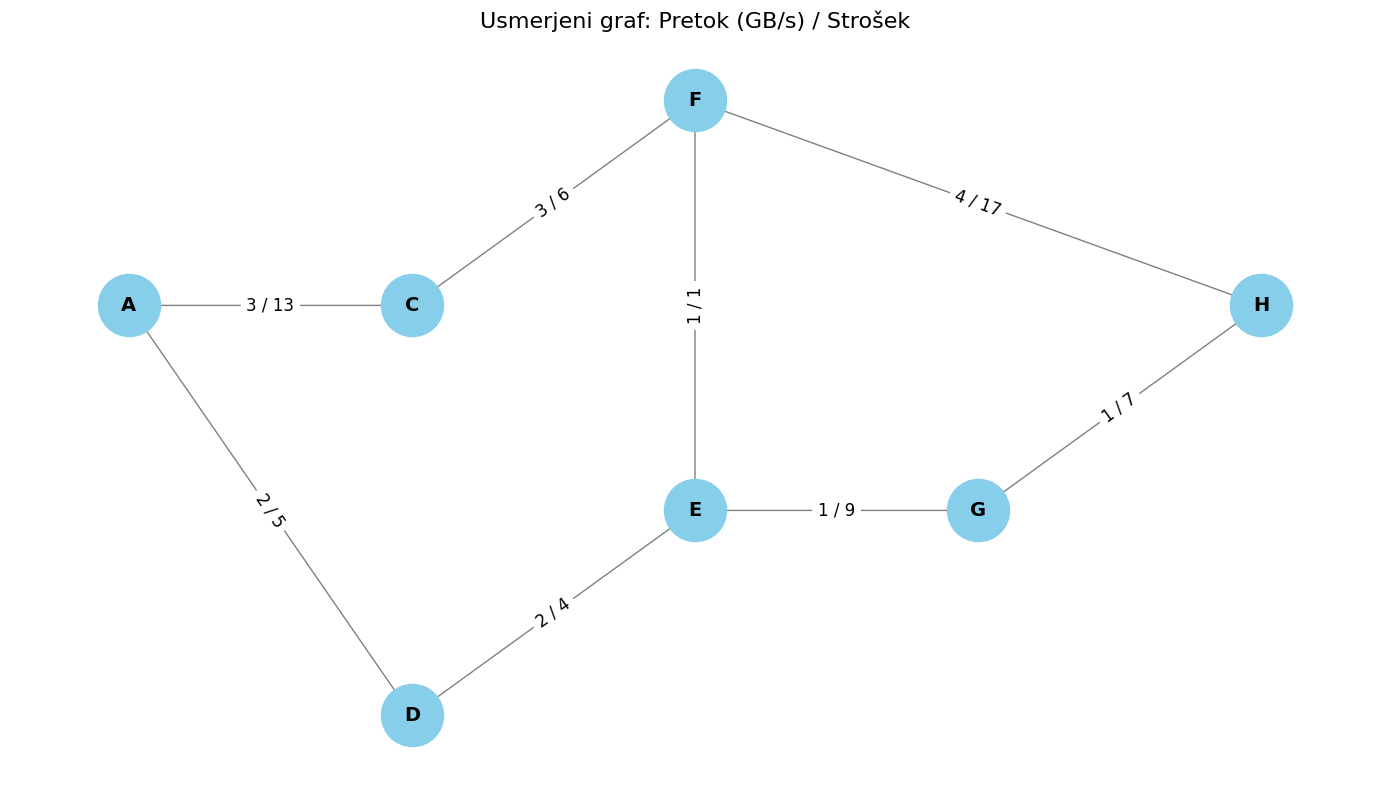

Tabela optimalnega pretoka:
  From To  Flow (GB/s)  Cost per GB  Total Cost
0    A  C            3           13          39
1    A  D            2            5          10
2    C  F            3            6          18
3    D  E            2            4           8
4    F  H            4           17          68
5    E  F            1            1           1
6    E  G            1            9           9
7    G  H            1            7           7

Skupni strošek prenosa: 160 enot


In [4]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

# 1. Definicija stroškov povezav (dolžin/tež)
edges_cost = {
    ('A', 'B'): 15, ('A', 'C'): 13, ('A', 'D'): 5,
    ('B', 'C'): 2, ('B', 'F'): 8, ('B', 'H'): 11,
    ('C', 'B'): 2, ('C', 'E'): 3, ('C', 'F'): 6,
    ('D', 'C'): 18, ('D', 'E'): 4, ('D', 'I'): 99,
    ('E', 'F'): 1, ('E', 'G'): 9, ('E', 'I'): 14,
    ('F', 'G'): 16, ('F', 'H'): 17,
    ('G', 'H'): 7, ('G', 'I'): 10,
    ('H', 'I'): 12
}

# 2. Simuliran optimalen pretok (lahko zamenjaš s PuLP rešitvijo)
simulated_flow = {
    ('A', 'C'): 3,
    ('A', 'D'): 2,
    ('C', 'F'): 3,
    ('D', 'E'): 2,
    ('E', 'F'): 1,
    ('F', 'H'): 4,
    ('E', 'G'): 1,
    ('G', 'H'): 1,
}

# 3. Ustvari graf
G = nx.DiGraph()
for (u, v), flow_val in simulated_flow.items():
    G.add_edge(u, v, flow=flow_val, cost=edges_cost.get((u, v), 0))

# 4. Pozicije za vozlišča (prilagojene)
pos = {
    'A': (0, 2),
    'B': (1, 3), 'C': (1, 2), 'D': (1, 1),
    'E': (2, 1.5), 'F': (2, 2.5),
    'G': (3, 1.5), 'H': (4, 2), 'I': (4, 1),
}

# 5. Nariši graf
plt.figure(figsize=(14, 8))
nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=2000)
nx.draw_networkx_labels(G, pos, font_size=14, font_weight='bold')
nx.draw_networkx_edges(G, pos, edge_color='gray', arrows=True, arrowsize=25)

# 6. Oznake na povezavah (pretok / strošek)
edge_labels = {(u, v): f"{G[u][v]['flow']} / {G[u][v]['cost']}" for u, v in G.edges()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=12)

plt.title("Usmerjeni graf: Pretok (GB/s) / Strošek", fontsize=16)
plt.axis("off")
plt.tight_layout()
plt.show()

# 7. Tabela z rezultati
df = pd.DataFrame([
    {
        "From": u,
        "To": v,
        "Flow (GB/s)": G[u][v]["flow"],
        "Cost per GB": G[u][v]["cost"],
        "Total Cost": G[u][v]["flow"] * G[u][v]["cost"]
    }
    for u, v in G.edges()
])

print("Tabela optimalnega pretoka:")
print(df)
print("\nSkupni strošek prenosa:", df["Total Cost"].sum(), "enot")

In [10]:
import pulp
import pandas as pd

# Strežniki
servers = ['s1', 's2', 's3', 's4']
server_costs = {'s1': 2000, 's2': 3000, 's3': 2000, 's4': 4000}
server_bandwidth = {'s1': 3, 's2': 2, 's3': 2, 's4': 4}

# Mesta (klienti)
cities = ['c1', 'c2', 'c3']
city_bandwidth = {'c1': 2.5, 'c2': 2, 'c3': 3}

# Cena prenosa
revenue_per_tbs = 3000

# Model
prob = pulp.LpProblem("MaxProfit_Server_Selection", pulp.LpMaximize)

# Spremenljivke
server_used = pulp.LpVariable.dicts("UseServer", servers, cat='Binary')
flow = pulp.LpVariable.dicts("Flow", [(s, c) for s in servers for c in cities], lowBound=0)

# Kriterijska funkcija
revenue = pulp.lpSum([flow[(s, c)] * revenue_per_tbs for s in servers for c in cities])
cost = pulp.lpSum([server_costs[s] * server_used[s] for s in servers])
prob += revenue - cost, "TotalProfit"

# Omejitve: potrebe mest
for c in cities:
    prob += pulp.lpSum([flow[(s, c)] for s in servers]) >= city_bandwidth[c]

# Omejitve: zmogljivost strežnikov
for s in servers:
    prob += pulp.lpSum([flow[(s, c)] for c in cities]) <= server_bandwidth[s] * server_used[s]

# Rešitev
prob.solve()

# Izpis rezultatov
print("Status:", pulp.LpStatus[prob.status])
print("⬛️ Skupni dobiček:", pulp.value(prob.objective), "EUR")

print("\n📦 Izbrani strežniki:")
for s in servers:
    if pulp.value(server_used[s]) > 0.5:
        print(f"  ✔ {s} (cena: {server_costs[s]} €, kapaciteta: {server_bandwidth[s]} Tbs)")

print("\n🔄 Podatkovni pretoki:")
rows = []
for s in servers:
    for c in cities:
        val = pulp.value(flow[(s, c)])
        if val > 0:
            print(f"  {s} ➝ {c}: {val:.2f} Tbs  ({val * revenue_per_tbs:.0f} € prihodka)")
            rows.append({
                "From Server": s, "To City": c, "Flow (Tbs)": val, "Revenue (€)": val * revenue_per_tbs
            })

# Tabela (pandas)
df = pd.DataFrame(rows)
display(df)

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/brinsoko/Documents/Faks/Magisterij/2. semeste/Optimizacija/.venv/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/hc/mvq6z20d5k5g768_4jg_bjfh0000gn/T/9420ea2085d141baaa53e5634147ad4c-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/hc/mvq6z20d5k5g768_4jg_bjfh0000gn/T/9420ea2085d141baaa53e5634147ad4c-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 12 COLUMNS
At line 65 RHS
At line 73 BOUNDS
At line 78 ENDATA
Problem MODEL has 7 rows, 16 columns and 28 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 22000 - 0.00 seconds
Cgl0004I processed model has 7 rows, 12 columns (0 integer (0 of which binary)) and 24 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from -22000 to -1.79769e+

,From Server,To City,Flow (Tbs),Revenue (€)
0,s1,c2,3.0,9000.0
1,s2,c1,0.5,1500.0
2,s2,c2,1.5,4500.0
3,s3,c1,2.0,6000.0
4,s4,c3,4.0,12000.0


In [11]:
import networkx as nx

# Stroški povezav (na GB)
edges_cost = {
    ('A', 'B'): 15, ('A', 'C'): 13, ('A', 'D'): 5,
    ('B', 'C'): 2, ('B', 'F'): 8, ('B', 'H'): 11,
    ('C', 'B'): 2, ('C', 'E'): 3, ('C', 'F'): 6,
    ('D', 'C'): 18, ('D', 'E'): 4, ('D', 'I'): 99,
    ('E', 'F'): 1, ('E', 'G'): 9, ('E', 'I'): 14,
    ('F', 'G'): 16, ('F', 'H'): 17,
    ('G', 'H'): 7, ('G', 'I'): 10,
    ('H', 'I'): 12
}

# Kapacitete povezav (dejanske vrednosti – zdaj bolj realne)
edges_capacity = {
    ('A', 'B'): 10, ('A', 'C'): 20, ('A', 'D'): 15,
    ('B', 'C'): 5, ('B', 'F'): 8, ('B', 'H'): 12,
    ('C', 'B'): 5, ('C', 'E'): 6, ('C', 'F'): 20,
    ('D', 'C'): 10, ('D', 'E'): 10, ('D', 'I'): 10,
    ('E', 'F'): 15, ('E', 'G'): 20, ('E', 'I'): 15,
    ('F', 'G'): 8, ('F', 'H'): 20,
    ('G', 'H'): 20, ('G', 'I'): 12,
    ('H', 'I'): 15
}

# Zgradimo graf samo s povezavami, ki imajo kapaciteto ≥ 20
G = nx.DiGraph()
for (u, v), cost in edges_cost.items():
    if edges_capacity.get((u, v), 0) >= 20:
        G.add_edge(u, v, weight=cost)

# Poskus najti najkrajšo možno pot za 20 GB/s
try:
    path = nx.shortest_path(G, source='A', target='H', weight='weight')
    cost = sum(edges_cost[(path[i], path[i+1])] * 20 for i in range(len(path) - 1))
    path_string = "-".join(path)

    result = {
        "path": path_string,
        "total_cost": cost,
        "status": " Pot najdena"
    }
except nx.NetworkXNoPath:
    result = {
        "path": None,
        "total_cost": None,
        "status": " Ni poti z dovolj veliko kapaciteto za 20 GB/s"
    }

result

{'path': 'A-C-F-H', 'total_cost': 720, 'status': ' Pot najdena'}

In [12]:
#Naloga 3

import pulp
import pandas as pd

# Strežniki
servers = ['s1', 's2', 's3', 's4']
server_costs = {'s1': 2000, 's2': 3000, 's3': 2000, 's4': 4000}
server_bandwidth = {'s1': 3, 's2': 2, 's3': 2, 's4': 4}

# Mesta (klienti)
cities = ['c1', 'c2', 'c3']
city_bandwidth = {'c1': 2.5, 'c2': 2, 'c3': 3}

# Cena prenosa
revenue_per_tbs = 3000

# Model
prob = pulp.LpProblem("MaxProfit_Server_Selection", pulp.LpMaximize)

# Spremenljivke
server_used = pulp.LpVariable.dicts("UseServer", servers, cat='Binary')
flow = pulp.LpVariable.dicts("Flow", [(s, c) for s in servers for c in cities], lowBound=0)

# Kriterijska funkcija
revenue = pulp.lpSum([flow[(s, c)] * revenue_per_tbs for s in servers for c in cities])
cost = pulp.lpSum([server_costs[s] * server_used[s] for s in servers])
prob += revenue - cost, "TotalProfit"

# Omejitve: potrebe mest
for c in cities:
    prob += pulp.lpSum([flow[(s, c)] for s in servers]) >= city_bandwidth[c]

# Omejitve: zmogljivost strežnikov
for s in servers:
    prob += pulp.lpSum([flow[(s, c)] for c in cities]) <= server_bandwidth[s] * server_used[s]

# Rešitev
prob.solve()

# Izpis rezultatov
print("Status:", pulp.LpStatus[prob.status])
print("⬛️ Skupni dobiček:", pulp.value(prob.objective), "EUR")

print("\n📦 Izbrani strežniki:")
for s in servers:
    if pulp.value(server_used[s]) > 0.5:
        print(f"  ✔ {s} (cena: {server_costs[s]} €, kapaciteta: {server_bandwidth[s]} Tbs)")

print("\n🔄 Podatkovni pretoki:")
rows = []
for s in servers:
    for c in cities:
        val = pulp.value(flow[(s, c)])
        if val > 0:
            print(f"  {s} ➝ {c}: {val:.2f} Tbs  ({val * revenue_per_tbs:.0f} € prihodka)")
            rows.append({
                "From Server": s, "To City": c, "Flow (Tbs)": val, "Revenue (€)": val * revenue_per_tbs
            })

# Tabela (pandas)
df = pd.DataFrame(rows)
display(df)

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/brinsoko/Documents/Faks/Magisterij/2. semeste/Optimizacija/.venv/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/hc/mvq6z20d5k5g768_4jg_bjfh0000gn/T/97f84d1190b14bcd8088d54aa4a0dadb-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/hc/mvq6z20d5k5g768_4jg_bjfh0000gn/T/97f84d1190b14bcd8088d54aa4a0dadb-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 12 COLUMNS
At line 65 RHS
At line 73 BOUNDS
At line 78 ENDATA
Problem MODEL has 7 rows, 16 columns and 28 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 22000 - 0.00 seconds
Cgl0004I processed model has 7 rows, 12 columns (0 integer (0 of which binary)) and 24 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from -22000 to -1.79769e+

,From Server,To City,Flow (Tbs),Revenue (€)
0,s1,c2,3.0,9000.0
1,s2,c1,0.5,1500.0
2,s2,c2,1.5,4500.0
3,s3,c1,2.0,6000.0
4,s4,c3,4.0,12000.0


In [13]:
import pulp
import pandas as pd

# Strežniki in njihove kapacitete (v Tbs)
servers = ['s1', 's2', 's3', 's4']
server_bandwidth = {'s1': 3, 's2': 2, 's3': 2, 's4': 4}

# Odjemalci (mesta) in njihova zahteva
cities = ['c1', 'c2', 'c3']
city_bandwidth = {'c1': 2.5, 'c2': 2, 'c3': 3}

# Cena prenosa
revenue_per_tbs = 3000

# Problem
prob = pulp.LpProblem("Maximize_Revenue_FixedServers", pulp.LpMaximize)

# Spremenljivke: pretok med strežnikom in mestom
flow = pulp.LpVariable.dicts("Flow", [(s, c) for s in servers for c in cities], lowBound=0)

# Ciljna funkcija: skupni prihodki
prob += pulp.lpSum([flow[(s, c)] * revenue_per_tbs for s in servers for c in cities])

# Zahteve mest (mora biti zadostno povpraševanje)
for c in cities:
    prob += pulp.lpSum([flow[(s, c)] for s in servers]) >= city_bandwidth[c]

# Strežniške kapacitete
for s in servers:
    prob += pulp.lpSum([flow[(s, c)] for c in cities]) <= server_bandwidth[s]

# Reši
prob.solve()

# Prikaz rezultatov v tabeli
table = []
for s in servers:
    row = {'Server Location': s, 'Server leased (0/1)': 1}
    used = 0
    for c in cities:
        val = pulp.value(flow[(s, c)])
        row[f'City {c[-1]} (Tbs)'] = round(val, 2)
        used += val
    row['Unused server capacity'] = round(server_bandwidth[s] - used, 2)
    table.append(row)

df = pd.DataFrame(table).set_index("Server Location")
display(df)

# Analiza
print("\n💰 Skupni prihodek:", pulp.value(prob.objective), "€")

max_revenue = sum(city_bandwidth[c] * revenue_per_tbs for c in cities)
if pulp.value(prob.objective) < max_revenue:
    print("⚠️ Profit omejujejo kapacitete strežnikov.")
else:
    print("✅ Vsa povpraševanja so zadostno pokrita.")

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/brinsoko/Documents/Faks/Magisterij/2. semeste/Optimizacija/.venv/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/hc/mvq6z20d5k5g768_4jg_bjfh0000gn/T/8398dc0e32a94774ab4dc2be5dd9c041-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/hc/mvq6z20d5k5g768_4jg_bjfh0000gn/T/8398dc0e32a94774ab4dc2be5dd9c041-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 12 COLUMNS
At line 49 RHS
At line 57 BOUNDS
At line 58 ENDATA
Problem MODEL has 7 rows, 12 columns and 24 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 7 (0) rows, 12 (0) columns and 24 (0) elements
Perturbing problem by 0.001% of 3000 - largest nonzero change 0.01521867 ( 0.000507289%) - largest zero change 0
0  Obj -0 Primal inf 7.4999997 (3) Dual inf 35999.849 (12)
0  Obj -0 Primal inf 7.499

,Server leased (0/1),City 1 (Tbs),City 2 (Tbs),City 3 (Tbs),Unused server capacity
Server Location,,,,,
s1,1,0.0,0.0,3.0,0.0
s2,1,0.0,2.0,0.0,0.0
s3,1,0.0,0.0,2.0,0.0
s4,1,4.0,0.0,0.0,0.0



💰 Skupni prihodek: 33000.0 €
✅ Vsa povpraševanja so zadostno pokrita.


In [ ]:
#3 B

import pulp
import pandas as pd

# Strežniške lokacije in podatki (nastavljivi!)
servers = ['s1', 's2', 's3', 's4']
server_costs = {'s1': 1800, 's2': 2700, 's3': 1800, 's4': 3500}
server_bandwidth = {'s1': 4, 's2': 3, 's3': 3, 's4': 4}

# Odjemalci (mesta)
cities = ['c1', 'c2', 'c3']
city_bandwidth = {'c1': 2.5, 'c2': 2, 'c3': 3}

# Cena za prenos (na Tbs)
revenue_per_tbs = 3200

# Model: maksimizacija profita
prob = pulp.LpProblem("MaxProfit_Optimized", pulp.LpMaximize)

# Dvojiške spremenljivke – ali zakupimo strežnik
server_used = pulp.LpVariable.dicts("UseServer", servers, cat='Binary')

# Spremenljivke – prenos podatkov med s in c
flow = pulp.LpVariable.dicts("Flow", [(s, c) for s in servers for c in cities], lowBound=0)

# Ciljna funkcija: prihodki – stroški
revenue = pulp.lpSum([flow[(s, c)] * revenue_per_tbs for s in servers for c in cities])
cost = pulp.lpSum([server_costs[s] * server_used[s] for s in servers])
prob += revenue - cost

# Povpraševanje strank
for c in cities:
    prob += pulp.lpSum([flow[(s, c)] for s in servers]) >= city_bandwidth[c]

# Strežniške kapacitete
for s in servers:
    prob += pulp.lpSum([flow[(s, c)] for c in cities]) <= server_bandwidth[s] * server_used[s]

# Reši
prob.solve()

# Prikaz rezultatov
print("🔢 Optimalen Zaslužek:", pulp.value(prob.objective), "EUR")

rows = []
for s in servers:
    row = {"Server Location": s, "Server leased (0/1)": int(pulp.value(server_used[s]))}
    total_used = 0
    for c in cities:
        flow_val = pulp.value(flow[(s, c)])
        row[f"City {c[-1]} (Tbs)"] = round(flow_val, 2)
        total_used += flow_val
    row["Unused server capacity"] = round(server_bandwidth[s] * pulp.value(server_used[s]) - total_used, 2)
    rows.append(row)

df = pd.DataFrame(rows)
df.set_index("Server Location", inplace=True)
display(df)

# Dodatna analiza
max_revenue = sum(city_bandwidth[c] * revenue_per_tbs for c in cities)
profit_gap = max_revenue - pulp.value(prob.objective)

print("\n📊 Teoretični max prihodek:", max_revenue, "EUR")
if profit_gap > 0:
    print("⚠️ Omejitve: Strežniške kapacitete ali stroški zakupov omejujejo maksimalen zaslužek.")
    print("🧮 Izgubljeni potencialni profit:", profit_gap, "EUR")
else:
    print("✅ Vsa povpraševanja pokrita – dosežen maksimalen možen prihodek.")

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/brinsoko/Documents/Faks/Magisterij/2. semeste/Optimizacija/.venv/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/hc/mvq6z20d5k5g768_4jg_bjfh0000gn/T/e05f333a2db94267a9c0c9e8f1790889-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/hc/mvq6z20d5k5g768_4jg_bjfh0000gn/T/e05f333a2db94267a9c0c9e8f1790889-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 12 COLUMNS
At line 65 RHS
At line 73 BOUNDS
At line 78 ENDATA
Problem MODEL has 7 rows, 16 columns and 28 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 35000 - 0.00 seconds
Cgl0004I processed model has 7 rows, 12 columns (0 integer (0 of which binary)) and 24 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from -35000 to -1.79769e+

,Server leased (0/1),City 1 (Tbs),City 2 (Tbs),City 3 (Tbs),Unused server capacity
Server Location,,,,,
s1,1,0.0,4.0,0.0,0.0
s2,1,0.0,3.0,0.0,0.0
s3,1,3.0,0.0,0.0,0.0
s4,1,0.0,0.0,4.0,0.0



📊 Teoretični max prihodek: 24000.0 EUR
✅ Vsa povpraševanja pokrita – dosežen maksimalen možen prihodek.


In [ ]:
#3 C


import pulp
import pandas as pd

# Definicija strežnikov
servers = ['s1', 's2', 's3', 's4']
server_costs = {'s1': 2000, 's2': 3000, 's3': 2000, 's4': 4000}
server_bandwidth = {'s1': 3, 's2': 2, 's3': 2, 's4': 4}

# Definicija klientov
cities = ['c1', 'c2', 'c3']
city_bandwidth = {'c1': 2.5, 'c2': 2, 'c3': 3}

# Cena na Tbs
revenue_per_tbs = 3000

# Problem: maksimizacija profita
prob = pulp.LpProblem("Maximize_Profit_With_Lease", pulp.LpMaximize)

# Spremenljivke: lease strežnikov (binarno)
lease = pulp.LpVariable.dicts("Lease", servers, cat="Binary")

# Pretok: koliko vsak server pošlje vsakemu mestu
flow = pulp.LpVariable.dicts("Flow", [(s, c) for s in servers for c in cities], lowBound=0)

# Kriterijska funkcija: prihodki - stroški strežnikov
revenue = pulp.lpSum([flow[(s, c)] * revenue_per_tbs for s in servers for c in cities])
costs = pulp.lpSum([lease[s] * server_costs[s] for s in servers])
prob += revenue - costs, "Total_Profit"

# Zahteve mest
for c in cities:
    prob += pulp.lpSum([flow[(s, c)] for s in servers]) >= city_bandwidth[c]

# Kapaciteta vsakega strežnika (če je najet)
for s in servers:
    prob += pulp.lpSum([flow[(s, c)] for c in cities]) <= server_bandwidth[s] * lease[s]

# Rešitev
prob.solve()

# Prikaz rezultatov
print("🔢 Optimalen Profit:", pulp.value(prob.objective), "EUR")

rows = []
for s in servers:
    row = {"Server Location": s, "Server leased (0/1)": int(pulp.value(lease[s]))}
    used = 0
    for c in cities:
        flow_val = pulp.value(flow[(s, c)])
        row[f"City {c[-1]} (Tbs)"] = round(flow_val, 2)
        used += flow_val
    capacity_used = round(server_bandwidth[s] * pulp.value(lease[s]) - used, 2)
    row["Unused server capacity"] = capacity_used
    rows.append(row)

df = pd.DataFrame(rows)
df.set_index("Server Location", inplace=True)
display(df)

# Analiza
max_revenue = sum(city_bandwidth[c] * revenue_per_tbs for c in cities)
print("\n📊 Teoretični prihodki (če bi bila kapaciteta neomejena):", max_revenue, "EUR")
print("⚙️ Uporabljeni strežniki:")
for s in servers:
    if pulp.value(lease[s]) > 0.5:
        print(f"  ✔ {s} (Najemnina: {server_costs[s]} €, Kapaciteta: {server_bandwidth[s]} Tbs)")

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/brinsoko/Documents/Faks/Magisterij/2. semeste/Optimizacija/.venv/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/hc/mvq6z20d5k5g768_4jg_bjfh0000gn/T/ae03917c09f248159ea5f924132aaf42-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/hc/mvq6z20d5k5g768_4jg_bjfh0000gn/T/ae03917c09f248159ea5f924132aaf42-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 12 COLUMNS
At line 65 RHS
At line 73 BOUNDS
At line 78 ENDATA
Problem MODEL has 7 rows, 16 columns and 28 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 22000 - 0.00 seconds
Cgl0004I processed model has 7 rows, 12 columns (0 integer (0 of which binary)) and 24 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from -22000 to -1.79769e+

,Server leased (0/1),City 1 (Tbs),City 2 (Tbs),City 3 (Tbs),Unused server capacity
Server Location,,,,,
s1,1,0.0,3.0,0.0,0.0
s2,1,0.5,1.5,0.0,0.0
s3,1,2.0,0.0,0.0,0.0
s4,1,0.0,0.0,4.0,0.0



📊 Teoretični prihodki (če bi bila kapaciteta neomejena): 22500.0 EUR
⚙️ Uporabljeni strežniki:
  ✔ s1 (Najemnina: 2000 €, Kapaciteta: 3 Tbs)
  ✔ s2 (Najemnina: 3000 €, Kapaciteta: 2 Tbs)
  ✔ s3 (Najemnina: 2000 €, Kapaciteta: 2 Tbs)
  ✔ s4 (Najemnina: 4000 €, Kapaciteta: 4 Tbs)


In [16]:
#3 D

import pulp
import pandas as pd

# Strežniki
servers = ['s1', 's2', 's3', 's4']
server_costs = {'s1': 2000, 's2': 3000, 's3': 2000, 's4': 4000}
server_bandwidth = {'s1': 3, 's2': 2, 's3': 2, 's4': 4}

# Klienti (zahteve + cene na Tbs)
cities = ['c1', 'c2', 'c3', 'c4', 'c5']
city_bandwidth = {'c1': 3.5, 'c2': 3, 'c3': 4, 'c4': 2.5, 'c5': 2}
city_price = {'c1': 2800, 'c2': 3200, 'c3': 3500, 'c4': 2500, 'c5': 2000}

# Model
prob = pulp.LpProblem("Maximize_Profit_Dynamic", pulp.LpMaximize)

# Spremenljivke
lease = pulp.LpVariable.dicts("Lease", servers, cat="Binary")
flow = pulp.LpVariable.dicts("Flow", [(s, c) for s in servers for c in cities], lowBound=0)

# Prihodki in stroški
revenue = pulp.lpSum([flow[(s, c)] * city_price[c] for s in servers for c in cities])
cost = pulp.lpSum([lease[s] * server_costs[s] for s in servers])
prob += revenue - cost

# Kapacitete serverjev
for s in servers:
    prob += pulp.lpSum([flow[(s, c)] for c in cities]) <= server_bandwidth[s] * lease[s]

# Zahteve klientov (mehka omejitev – ne večja od)
for c in cities:
    prob += pulp.lpSum([flow[(s, c)] for s in servers]) <= city_bandwidth[c]

# Rešitev
prob.solve()

# Tabela rezultatov
rows = []
for s in servers:
    row = {"Server Location": s, "Server leased (0/1)": int(pulp.value(lease[s]))}
    used = 0
    for c in cities:
        fval = pulp.value(flow[(s, c)])
        row[f"City {c[-1]} (Tbs)"] = round(fval, 2)
        used += fval
    row["Unused server capacity"] = round(server_bandwidth[s] * pulp.value(lease[s]) - used, 2)
    rows.append(row)

df = pd.DataFrame(rows)
df.set_index("Server Location", inplace=True)
display(df)

# Dodatna analiza
client_allocation = {
    c: round(sum(pulp.value(flow[(s, c)]) for s in servers), 2)
    for c in cities
}

total_profit = pulp.value(prob.objective)
max_possible_revenue = sum(city_bandwidth[c] * city_price[c] for c in cities)

print("\n📈 Dosežen profit:", total_profit, "EUR")
print("📊 Teoretični max prihodek (če bi pokrili vse potrebe):", max_possible_revenue, "EUR")
print("❗ Razlika:", max_possible_revenue - total_profit, "EUR")

print("\n🔍 Klienti, ki prejmejo največ podatkov:")
for c, amount in sorted(client_allocation.items(), key=lambda x: (-x[1], -city_price[x[0]])):
    print(f"  {c}: {amount} Tbs (cena: {city_price[c]} €/Tbs)")

print("\n⚠️ Omejitve:")
print("  Skupna razpoložljiva kapaciteta strežnikov =", sum(server_bandwidth[s] for s in servers), "Tbs")
print("  Skupne potrebe klientov =", sum(city_bandwidth[c] for c in cities), "Tbs")

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/brinsoko/Documents/Faks/Magisterij/2. semeste/Optimizacija/.venv/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/hc/mvq6z20d5k5g768_4jg_bjfh0000gn/T/c18aa09c9c9a4f1597d366653591426e-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/hc/mvq6z20d5k5g768_4jg_bjfh0000gn/T/c18aa09c9c9a4f1597d366653591426e-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 14 COLUMNS
At line 91 RHS
At line 101 BOUNDS
At line 106 ENDATA
Problem MODEL has 9 rows, 24 columns and 44 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 23650 - 0.00 seconds
Cgl0004I processed model has 9 rows, 24 columns (4 integer (4 of which binary)) and 44 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 2.22045e-16
Cbc0038I Solution found of -23650
Cbc00

,Server leased (0/1),City 1 (Tbs),City 2 (Tbs),City 3 (Tbs),City 4 (Tbs),City 5 (Tbs),Unused server capacity
Server Location,,,,,,,
s1,1,3.0,0.0,0.0,0.0,0.0,0.0
s2,1,0.5,1.0,0.0,0.5,0.0,0.0
s3,1,0.0,2.0,0.0,0.0,0.0,0.0
s4,1,0.0,0.0,4.0,0.0,0.0,0.0



📈 Dosežen profit: 23650.0 EUR
📊 Teoretični max prihodek (če bi pokrili vse potrebe): 43650.0 EUR
❗ Razlika: 20000.0 EUR

🔍 Klienti, ki prejmejo največ podatkov:
  c3: 4.0 Tbs (cena: 3500 €/Tbs)
  c1: 3.5 Tbs (cena: 2800 €/Tbs)
  c2: 3.0 Tbs (cena: 3200 €/Tbs)
  c4: 0.5 Tbs (cena: 2500 €/Tbs)
  c5: 0.0 Tbs (cena: 2000 €/Tbs)

⚠️ Omejitve:
  Skupna razpoložljiva kapaciteta strežnikov = 11 Tbs
  Skupne potrebe klientov = 15.0 Tbs


In [18]:
#3 E


import pulp
import pandas as pd

# Strežniki
servers = ['s1', 's2', 's3', 's4']
server_costs = {'s1': 2000, 's2': 3000, 's3': 2000, 's4': 4000}
server_bandwidth = {'s1': 3, 's2': 2, 's3': 2, 's4': 4}

# Klienti
cities = ['c1', 'c2', 'c3', 'c4', 'c5']
city_bandwidth = {'c1': 3.5, 'c2': 3, 'c3': 4, 'c4': 2.5, 'c5': 2}
city_price = {'c1': 2800, 'c2': 3200, 'c3': 3500, 'c4': 2500, 'c5': 2000}

# Omejitve povezav (v Tbs), 0 pomeni ni povezave
link_capacity = {
    ('s1', 'c1'): 2, ('s1', 'c2'): 0, ('s1', 'c3'): 1, ('s1', 'c4'): 1.5, ('s1', 'c5'): 0,
    ('s2', 'c1'): 0, ('s2', 'c2'): 2, ('s2', 'c3'): 1, ('s2', 'c4'): 0, ('s2', 'c5'): 1,
    ('s3', 'c1'): 0, ('s3', 'c2'): 0, ('s3', 'c3'): 2, ('s3', 'c4'): 1, ('s3', 'c5'): 2,
    ('s4', 'c1'): 3.5, ('s4', 'c2'): 1.5, ('s4', 'c3'): 2, ('s4', 'c4'): 2, ('s4', 'c5'): 2
}

# Problem
prob = pulp.LpProblem("MaxProfit_With_Link_Limits", pulp.LpMaximize)

# Spremenljivke
lease = pulp.LpVariable.dicts("Lease", servers, cat='Binary')
flow = pulp.LpVariable.dicts("Flow", link_capacity.keys(), lowBound=0)

# Ciljna funkcija
revenue = pulp.lpSum([flow[(s, c)] * city_price[c] for (s, c) in flow])
cost = pulp.lpSum([lease[s] * server_costs[s] for s in servers])
prob += revenue - cost

# Omejitve: strežniške kapacitete
for s in servers:
    prob += pulp.lpSum([flow[(s, c)] for c in cities if (s, c) in flow]) <= server_bandwidth[s] * lease[s]

# Omejitve: največja povpraševanja klientov
for c in cities:
    prob += pulp.lpSum([flow[(s, c)] for s in servers if (s, c) in flow]) <= city_bandwidth[c]

# Omejitve povezav
for (s, c), cap in link_capacity.items():
    prob += flow[(s, c)] <= cap

# Rešitev
prob.solve()

# Prikaz rezultatov
rows = []
for s in servers:
    row = {"Server Location": s, "Server leased (0/1)": int(pulp.value(lease[s]))}
    used = 0
    for c in cities:
        if (s, c) in flow:
            fval = pulp.value(flow[(s, c)])
            row[f"City {c[-1]} (Tbs)"] = round(fval, 2)
            used += fval
        else:
            row[f"City {c[-1]} (Tbs)"] = "-"
    row["Unused server capacity"] = round(server_bandwidth[s] * pulp.value(lease[s]) - used, 2)
    rows.append(row)

df = pd.DataFrame(rows)
df.set_index("Server Location", inplace=True)
display(df)

# Dodatna analiza
client_allocation = {
    c: round(sum(pulp.value(flow[(s, c)]) for s in servers if (s, c) in flow), 2)
    for c in cities
}

print("\n💰 Profit:", pulp.value(prob.objective), "EUR")
print("📈 Skupni promet k strankam (Tbs):")
for c in cities:
    print(f"  {c}: {client_allocation[c]} Tbs (max: {city_bandwidth[c]})")


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/brinsoko/Documents/Faks/Magisterij/2. semeste/Optimizacija/.venv/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/hc/mvq6z20d5k5g768_4jg_bjfh0000gn/T/7da24e30c0cb4f2493c39427e6bccd2d-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/hc/mvq6z20d5k5g768_4jg_bjfh0000gn/T/7da24e30c0cb4f2493c39427e6bccd2d-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 34 COLUMNS
At line 131 RHS
At line 161 BOUNDS
At line 166 ENDATA
Problem MODEL has 29 rows, 24 columns and 64 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 23650 - 0.00 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 2 strengthened rows, 0 substitutions
Cgl0004I processed model has 9 rows, 18 columns (4 integer (4 of which binary)) and 34 elements
Cbc0038I Initial state - 0 i

,Server leased (0/1),City 1 (Tbs),City 2 (Tbs),City 3 (Tbs),City 4 (Tbs),City 5 (Tbs),Unused server capacity
Server Location,,,,,,,
s1,1,1.5,0.0,1.0,0.5,0.0,0.0
s2,1,0.0,2.0,0.0,0.0,0.0,0.0
s3,1,0.0,0.0,2.0,0.0,0.0,0.0
s4,1,2.0,1.0,1.0,0.0,0.0,0.0



💰 Profit: 23650.0 EUR
📈 Skupni promet k strankam (Tbs):
  c1: 3.5 Tbs (max: 3.5)
  c2: 3.0 Tbs (max: 3)
  c3: 4.0 Tbs (max: 4)
  c4: 0.5 Tbs (max: 2.5)
  c5: 0.0 Tbs (max: 2)


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/brinsoko/Documents/Faks/Magisterij/2. semeste/Optimizacija/.venv/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/hc/mvq6z20d5k5g768_4jg_bjfh0000gn/T/d8366f2748264a2e9bfda4103aa5a6fe-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/hc/mvq6z20d5k5g768_4jg_bjfh0000gn/T/d8366f2748264a2e9bfda4103aa5a6fe-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 77 COLUMNS
At line 294 RHS
At line 367 BOUNDS
At line 368 ENDATA
Problem MODEL has 72 rows, 54 columns and 162 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 16 (-56) rows, 50 (-4) columns and 100 (-62) elements
Optimal - objective value 0
After Postsolve, objective 0, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective 0 - 0 iterations time 0.002, Presolve 0.00
Option for printingOptions ch

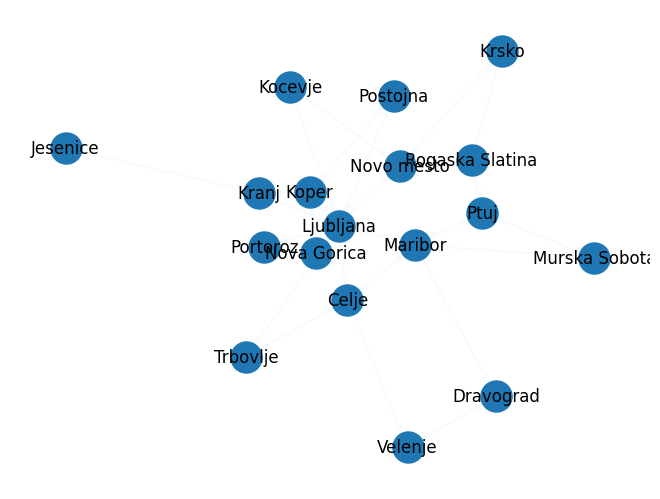

In [21]:
import networkx as nx
import matplotlib.pyplot as plt
import pulp

# 1. Nalaganje grafa
G = nx.read_graphml('Arnes_network.graphml')
G = nx.DiGraph(G)

# Preveri in dopolni manjkajoče atribute
for u, v in G.edges():
    if 'capacity' not in G[u][v]:
        G[u][v]['capacity'] = 100  # privzeta vrednost
    if 'cost' not in G[u][v]:
        G[u][v]['cost'] = 1        # ali uporabi 1 / G[u][v]['capacity']

# Preveri, ali graf vsebuje atribute 'capacity' in 'cost'
# Če ne, jih dodaj ročno, npr.:
# for u, v in G.edges():
#     G[u][v]['capacity'] = 100  # Primer kapacitete
#     G[u][v]['cost'] = 1        # Primer stroška

# 2. Definicija strežnikov in klientov
servers = {'Server1': 500, 'Server2': 300}  # Vozlišče: kapaciteta
clients = {'Client1': 200, 'Client2': 400}  # Vozlišče: zahteva

# 3. Modeliranje problema
prob = pulp.LpProblem("Minimize_Cost", pulp.LpMinimize)

# Spremenljivke za tokove po povezavah
flow = {}
for u, v in G.edges():
    flow[(u, v)] = pulp.LpVariable(f'flow_{u}_{v}', lowBound=0)

# Ciljna funkcija: minimizacija skupnih stroškov prenosa
prob += pulp.lpSum(flow[(u, v)] * G[u][v]['cost'] for u, v in G.edges())

# Omejitve kapacitet povezav
for u, v in G.edges():
    prob += flow[(u, v)] <= G[u][v]['capacity']

# Omejitve za strežnike in kliente
for node in G.nodes():
    inflow = pulp.lpSum(flow[(u, node)] for u in G.predecessors(node))
    outflow = pulp.lpSum(flow[(node, v)] for v in G.successors(node))
    if node in servers:
        prob += outflow - inflow == servers[node]
    elif node in clients:
        prob += inflow - outflow == clients[node]
    else:
        prob += inflow == outflow

# 4. Reševanje problema
prob.solve()

# 5. Vizualizacija rezultatov
pos = nx.spring_layout(G)
edge_colors = [flow[(u, v)].varValue for u, v in G.edges()]
nx.draw(G, pos, with_labels=True, edge_color=edge_colors, edge_cmap=plt.cm.Blues, node_size=500)
plt.show()